## Random Forest Baseline Quickstart for NetML-Competition 2020

### * Loads datasets, plots confusion matrix, prints evaluation metrics on validation set and create submission JSON files

In [1]:
import os
import json
import argparse
import time as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from utils.helper import *

In [2]:
# Define function to create submissions
def do_submit(clf, test_set, scaler, class_label_pair, filepath):
    Xtest, ids = get_submission_data(test_set)
    X_test_scaled = scaler.transform(Xtest)
    print("Predicting on {} ...".format(test_set.split('/')[-1]))
    predictions = clf.predict(X_test_scaled)
    make_submission(predictions, ids, class_label_pair, filepath)   

In [3]:
# Modify only this cell:
# Note: anno = "mid" is valid ONLY with non-vpn2016 dataset
###
dataset = "./data/CICIDS2017" # or "./data/CICIDS2017" or "./data/non-vpn2016"
anno = "fine" # or "mid" or "fine"
submit = "both" # or "test-std" or "test-challenge"
###

In [4]:
# Assign variables
training_set = dataset+"/2_training_set"
training_anno_file = dataset+"/2_training_annotations/2_training_anno_"+anno+".json.gz"
test_set = dataset+"/1_test-std_set"
challenge_set = dataset+"/0_test-challenge_set"

In [5]:
# Create folder for the results
time_ = t.strftime("%Y%m%d-%H%M%S")

save_dir = os.getcwd() + '/results/' + time_
os.makedirs(save_dir)

In [6]:
# Get training data in np.array format
Xtrain, ytrain, class_label_pair, Xtrain_ids = get_training_data(training_set, training_anno_file)

# Split validation set from training data
X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain,
                                                test_size=0.2, 
                                                random_state=42,
                                                stratify=ytrain)


Loading training set ...
Reading 2_training_set.json.gz


In [7]:
# Get name of each class to display in confusion matrix
class_names = list(sorted(class_label_pair.keys()))

# Preprocess the data
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [8]:
# Train RF Model
print("Training the model ...")

MLP = MLPClassifier(random_state=42, max_iter=350, early_stopping=True)

ET = ExtraTreesClassifier(n_estimators=150, random_state=42, n_jobs = -1)
RF = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs = -1, max_features="auto")

eclf = StackingClassifier(estimators=[('rfc', RF), ('etc', ET)],final_estimator=MLP ,n_jobs=-1)
eclf.fit(X_train_scaled, y_train)
print("votingclassifier")
print("Training Score: \t{:.5f}".format(eclf.score(X_train_scaled, y_train)))
print("Validation Score: \t{:.5f}".format(eclf.score(X_val_scaled, y_val)))

Training the model ...


MemoryError: Unable to allocate 2.15 MiB for an array with shape (282313,) and data type float64

In [10]:
# Output accuracy of classifier
print("eclf")
print("Training Score: \t{:.5f}".format(eclf.score(X_train_scaled, y_train)))
print("Validation Score: \t{:.5f}".format(eclf.score(X_val_scaled, y_val)))

eclf
Training Score: 	0.99457
Validation Score: 	0.99126


F1: 			0.99140
mAP: 			0.93189
Confusion matrix is saved as ./results/20210428-034006/CM.png



(<AxesSubplot:title={'center':'Confusion matrix, without normalization\nF1:0.99140 - mAP:0.93189'}, xlabel='Predicted label', ylabel='True label'>,
 array([[ 7227,     0,     0,     0,     0,     0,     0,     0],
        [    0,  4755,     4,     0,     0,     1,     0,     1],
        [    0,     1, 39465,     0,    51,     9,     0,   165],
        [    0,     0,     0,   632,     0,     0,     2,     0],
        [    0,     0,   483,     0, 10224,     0,     0,     0],
        [    0,     0,     4,     0,     0, 24482,     0,     0],
        [    0,     0,     0,     0,     0,     0,   395,     0],
        [    0,     0,    50,     0,     0,     0,     0,   273]],
       dtype=int64))

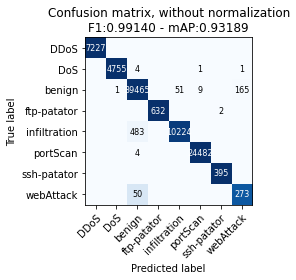

In [11]:
# Print Confusion Matrix
ypred = eclf.predict(X_val_scaled)

np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(directory=save_dir, y_true=y_val, y_pred=ypred, 
                        classes=class_names, 
                        normalize=False)

In [12]:
# Make submission with JSON format
if submit == "test-std" or submit == "both":
    do_submit(eclf, test_set, scaler, class_label_pair, save_dir+"/submission_test-std.json")
if submit == "test-challenge" or submit == "both":
    do_submit(eclf, challenge_set, scaler, class_label_pair, save_dir+"/submission_test-challenge.json")


Loading submission set ...
Reading 1_test-std_set.json.gz
Predicting on 1_test-std_set ...
Submission file is created as ./results/20210428-034006/submission_test-std.json

Loading submission set ...
Reading 0_test-challenge_set.json.gz
Predicting on 0_test-challenge_set ...
Submission file is created as ./results/20210428-034006/submission_test-challenge.json

